<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/master/Appendix_corrcoef_mixed2dGaussian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


様々なデータを解析する際
* 解析的な計算
* 数値的な計算

が相補的に役に立つことが多い。
たとえば手計算で行った式変形が正しいかどうかを、対応する数値計算の結果からある程度チェックできたり、
naiveに数値計算すると計算量が膨大になったり数値計算による誤差が紛れ込む場合でも、実はもう少し簡略化した解析的な式が導出できて、計算量を一気に減らせたり精度良く計算できるといったことがよくある。

ちなみにPython自体を使って(Sympyモジュール)ある程度の代数計算も可能である。  
(Pythonでなくても、Mathematicaなども有効な選択肢の一つになるが、所属機関がライセンスを購入しているかなどに依存するので、あまり万人にはオススメしにくい。)

## 混合２次元正規分布

異なる2次元の正規分布から生成されるサンプルの和集合を考えてみる。

以下では、異なる２つの集団から、同数ずつ選ばれた人に(集団からのサンプルが正規分布に従う)ある項目についてのアンケートを取った場合、のようなものを想定するとよい。

[マンモス高校Aの、センター試験国語と数学の得点],[マンモス高校Bの、センター試験国語と数学の得点]といったより具体的な例をイメージしてもよい。

集団1と集団2は、それぞれ対応する正規分布の中心および共分散行列(相関)によって特徴づけられる。

集団1,2での適当なx,yの平均値と共分散(相関)を指定する

In [160]:
import numpy as np
mu1 = [-1.0, 1.4];mu2 = [1.3, -0.4]
Sigma1= [ [ 1.0, 0.65], [0.65,1.0]] 
Sigma2= [ [ 1.0, -0.35], [-0.35,1.0]] 

２次元(多次元)正規分布に従う乱数は、numpyの```multivariate_normal()```を使えば生成することができて...

注) np.random.multivariate_normal()(というよりnp.random.normal())は昔(2018年くらい？)並列化した際にスレッドセーフでなかった記憶があります。今はどうか知りません。いずれにせよこのノートでは並列処理をしないので問題ないはず...。

In [161]:
numS = 500000
y1s = np.random.multivariate_normal(mu1,Sigma1,numS)
y2s = np.random.multivariate_normal(mu2,Sigma2,numS)
x1,y1 =y1s.T; x2,y2 =y2s.T
x = list(x1) + list(x2); y = list(y1) + list(y2)

プロットしてみると


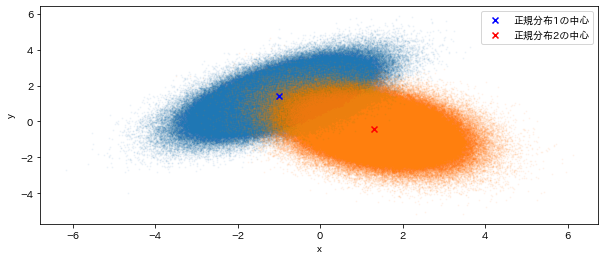

In [162]:
from matplotlib import pyplot as plt
!pip install japanize-matplotlib 
import japanize_matplotlib 

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)

ax.scatter(x1,y1,s=1,alpha=0.05); ax.scatter(x2,y2,s=1,alpha=0.05)
ax.scatter(mu1[0],mu1[1],color="blue",marker="x",label="正規分布1の中心")
ax.scatter(mu2[0],mu2[1],color="red",marker="x",label="正規分布2の中心")
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.legend()
plt.show()
plt.close()

集団1と集団2を合わせた全てのサンプルから、$x,y$それぞれの平均と分散, 共分散を計算してみると

In [163]:
sample_mean = [np.mean(x),np.mean(y)] #全体の平均
sample_var_x = np.var(x)
sample_var_y = np.var(y)
sample_cov = np.cov(x,y)

print("サンプル全体の中心", sample_mean)
print("xの分散:", str("%12.4f" % sample_var_x))
print("yの分散:",  str("%12.4f" % sample_var_y))
print("x-yの共分散:",  str("%12.4f" % sample_cov[0,1]))
print("相関係数", str("%12.4f" % (sample_cov[0,1]/(np.sqrt(sample_var_x)*np.sqrt(sample_var_y)))))

サンプル全体の中心 [0.15081301405859543, 0.4986599183285648]
xの分散:       2.3276
yの分散:       1.8094
x-yの共分散:      -0.8865
相関係数      -0.4320


この正規分布を考える(母集団を一つの正規分布で近似するのに相当)と

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


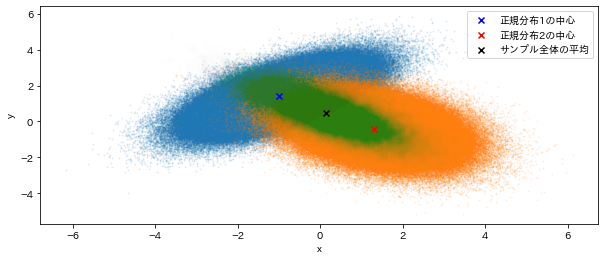

In [164]:
nSigma=np.array([[1.0, r],[r,1.0]])
ynews = np.random.multivariate_normal(sample_mean,nSigma,50000)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(111)
ax.set_xlabel("x"); ax.set_ylabel("y")
ax.scatter(x1,y1,s=1,alpha=0.1); ax.scatter(x2,y2,s=1,alpha=0.1)
ax.scatter(ynews.T[0],ynews.T[1],alpha=0.005) #かなり薄め(alpha:小)にした
ax.scatter(mu1[0],mu1[1],color="blue",marker="x",label="正規分布1の中心")
ax.scatter(mu2[0],mu2[1],color="red",marker="x",label="正規分布2の中心")
ax.scatter(sample_mean[0],sample_mean[1],color="k",marker="x",label="サンプル全体の平均")
ax.legend()
plt.show()
plt.close()

という感じになる。

さて、今のような正規分布1と正規分布2の中心および共分散行列が分かっている状況で、正規分布1と2から生成したサンプルを使って、緑の分布の中心と共分散を推定する、というのはサンプル数によっては精度が低くなってしまう。つまり効率がよくない。

慣れてくると、「正規分布は性質がよい確率分布であるので、なんとなくその重ね合わせの混合分布から生成される
サンプルの中心と共分散行列も、閉じた形で書けるっしょ!」と想像がつく。

(編集中)

さて、これを数値的に実装してみて、サンプル数を多く取った場合の上のコードの計算結果と比較してみよう。


まず以下の処理を行う関数を作成する。

1. 集団1と集団2の共分散行列の逆行列(精度行列)を求める



In [174]:
def calc_mean(mu1,mu2,fac=0.5):
    return fac * np.array(mu1) + (1-fac)* np.array(mu2)

def target_Integral(mu,Sigma,tot_mu,fac=0.5): # mu: mean vector. Sigma: covariance
    Lambda = np.linalg.inv(Sigma)
    detA = np.linalg.det(Lambda)
    Ax = Lambda[0,0]; Ay = Lambda[1,1]; Axy = Lambda[0,1]
    sigx2 = fac* ( Ay/detA + (mu[0]**2 - tot_mu[0]**2) )
    sigy2 = fac* ( Ax/detA + (mu[1]**2 - tot_mu[1]**2) )
    sigxy = fac* ( -Axy/(Ax*Ay-Axy**2)  + mu[0]*mu[1]  -tot_mu[0]*tot_mu[1] )
    return sigx2, sigy2, sigxy


今の場合、等価に足すので常に```fac=0.5```でOK。

In [175]:
mu = calc_mean(mu1,mu2) 
calc_var_x = 0.0
calc_var_y = 0.0
calc_cov = 0.0
# 集団1からの寄与
tmp = target_Integral(mu1,Sigma1,mu)
calc_var_x += tmp[0]; calc_var_y += tmp[1]; calc_cov += tmp[2]
# 集団2からの寄与
tmp = target_Integral(mu2,Sigma2,mu)
calc_var_x += tmp[0]; calc_var_y += tmp[1]; calc_cov += tmp[2]

r = calc_cov/ ( np.sqrt(calc_var_x)*np.sqrt(calc_var_y))

print("解析的")
print("中心", mu)
print("xの分散:", str("%12.3f" % calc_var_x))
print("yの分散:",  str("%12.3f" % calc_var_y))
print("x-yの共分散:",  str("%12.3f" % calc_cov))
print("相関係数", str("%12.3f" % r ))
print("")

print("サンプルから計算された量:")
print("中心",np.mean(x),np.mean(y))
print("xの分散:", str("%12.3f" % sample_var_x))
print("yの分散:",  str("%12.3f" % sample_var_y))
print("x-yの共分散:",  str("%12.3f" % sample_cov[0,1]))
print("相関係数", str("%12.3f" % (sample_cov[0,1]/(np.sqrt(sample_var_x)*np.sqrt(sample_var_y)))))

解析的
中心 [0.15 0.5 ]
xの分散:        2.323
yの分散:        1.810
x-yの共分散:       -0.885
相関係数       -0.432

サンプルから計算された量:
中心 0.15081301405859543 0.4986599183285648
xの分散:        2.328
yの分散:        1.809
x-yの共分散:       -0.886
相関係数       -0.432


となり、おおよそ一致する。

違いは、サンプル数が有限であることに由来する(サンプル数を少なくして初めから実行してみよう)。



## (編集中)

今度はちょうど逆を考える。

つまり全体のデータが手元にあるときに、いくつかの正規分布の重ね合わせとしてデータを表現することを考える。


これができると、(個々の集団の区別がつかず)全体の情報しかないアンケート結果を見たときにでも、いくつかのコミュニティ(クラスター)に分けた分析をしたり、といった応用が考えられる

今のデータの場合はplotすれば2個だと分かりそうなものだが、一般の場合やより多次元の場合は難しい。  
そこで、変分的に正規分布の数やパラメータ(中心,共分散)を変えながら混合ガウス分布で全体のデータを表現することを考える。